# Photometry data preprocessing

This notebook shows methods for preprocessing fiber photometry data. The preprocessing consists of the following steps:

1. Lowpass and median filtering to reduce noise and electrical artifacts.

2. Correction for photobleaching, i.e. the slow decreace in the fluorescence signal as flurophores are degraded by light exposure.  Three different methods are shown (i) highpass filtering with a very low cutoff frequency, (ii) Subtraction of a exponential fit (ii) Subtraction of a polynomial fit.

2. Movement correction.  Movement artifacts are estimated by a linear fit of the movement control channel to the GCaMP signal, then subtracted from the GCaMP signal.

4. Conversion of the signal to dF/F.

Note that different groups do preprocessing differently and there is no universally accepted best practice for how to preprocess photometry data.  The best way to preprocess your data will likely depend on the details of the experimental setup and the questions you want to ask of the data. It is good practice to always visually inspect the raw data and the results of each preprocessing step to make sure they look sensible.  

The data used in this notebook were recorded from dopamine neurons in mouse VTA during a reward guided decision task.  The data were recorded using [pyPhotometry](https://pyphotometry.readthedocs.io) acquisition hardware, using the *two colour time division* acquisition mode with GCaMP6f as the calcium indicator and TdTomato as a movement control channel.

Import the standard python modules needed for the analysis.

In [7]:
import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

Import the pyPhotometry [data import](https://pyphotometry.readthedocs.io/en/latest/user-guide/importing-data/) module.

In [3]:
from data_import import import_ppd

Import the data file.

In [4]:
data_folder = 'data'
data_filename = 'm17-R-2018-12-12-090409.ppd'
data = import_ppd(os.path.join(data_folder, data_filename))

Extract the raw GCaMP and TdTomato signals, session time, and sampling rate.

In [5]:
GCaMP_raw = data['analog_1']
TdTom_raw = data['analog_2']
time_seconds = data['time']/1000
sampling_rate = data['sampling_rate']

# Raw signals

Let's take a look at the raw GCaMP and TdTomato signals.

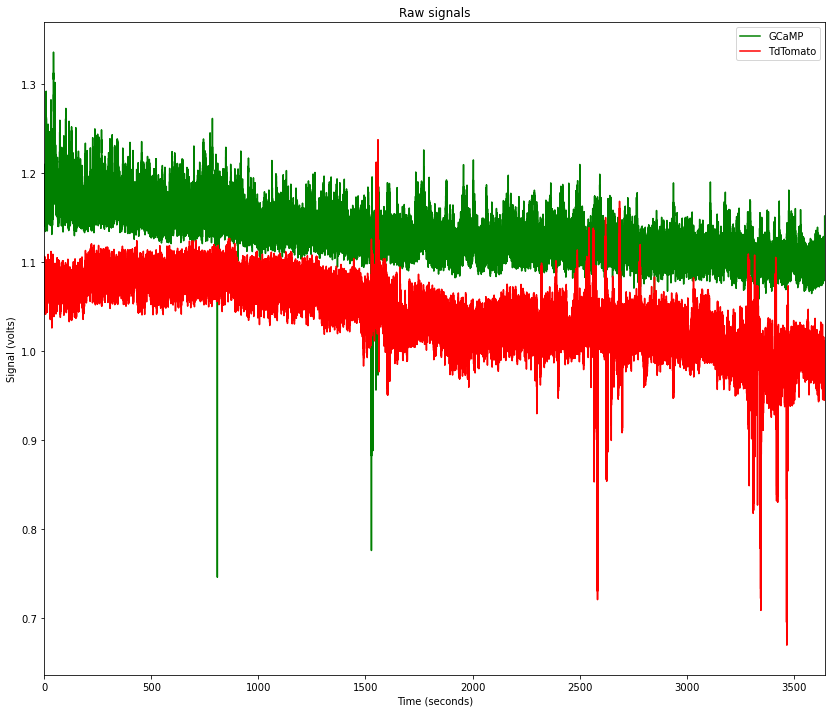

In [8]:
plt.plot(time_seconds, GCaMP_raw, 'g', label='GCaMP')
plt.plot(time_seconds, TdTom_raw, 'r', label='TdTomato')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Raw signals')
plt.legend();

# Denoising

This recording has large electrical noise artifacts, likely due to the high gain amplifiers in the photodetectors picking up signals from a nearby mobile phone.  The artifacts are very short pulses and can be greatly reduced by running a median filter before the standard low pass filter.  We then lowpass filter the signals to reduce noise, using a zero phase filter with a 10Hz cutoff frequency.

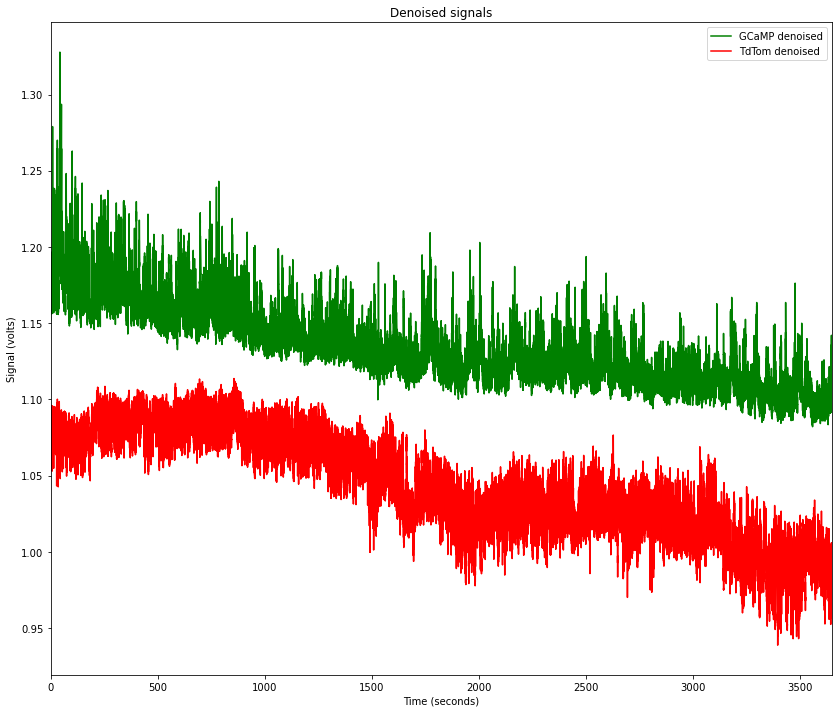

In [20]:
# Median filtering to remove electrical artifact.
GCaMP_denoised = medfilt(GCaMP_raw, kernel_size=5)
TdTom_denoised = medfilt(TdTom_raw, kernel_size=5)
 
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 10, btype='low', fs=sampling_rate)
GCaMP_denoised = filtfilt(b,a, GCaMP_denoised)
TdTom_denoised = filtfilt(b,a, TdTom_denoised)

#plt.plot(time_seconds, GCaMP_raw, label='GCaMP')
#plt.plot(time_seconds, TdTom_raw, label='TdTomato')
plt.plot(time_seconds, GCaMP_denoised, 'g', label='GCaMP denoised')
plt.plot(time_seconds, TdTom_denoised, 'r', label='TdTom denoised') 
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Denoised signals')
plt.legend();

Let's zoom in on the x axis to see how the lowpass filtering has smoothed the signals.

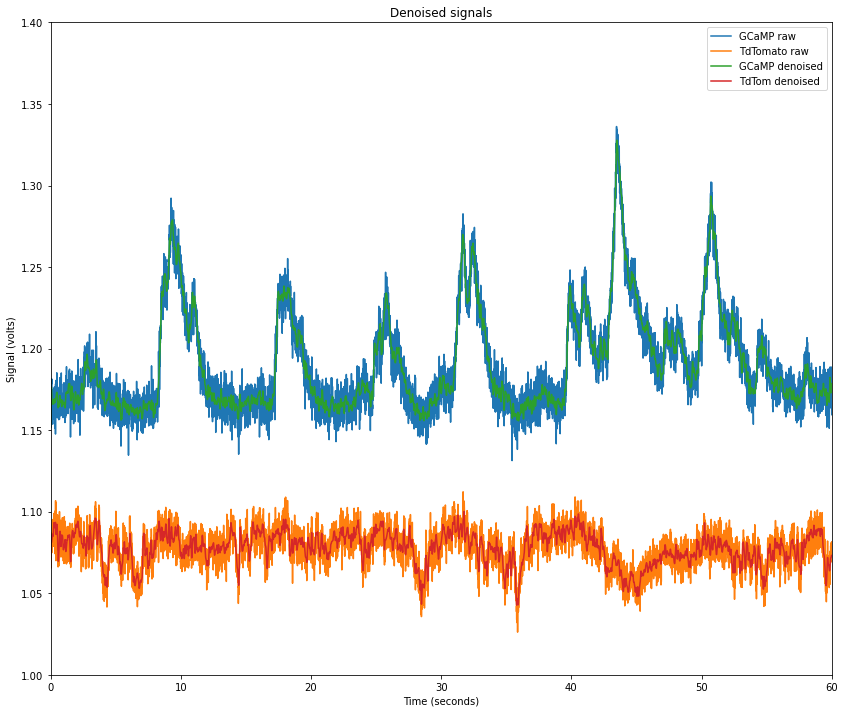

In [21]:
plt.plot(time_seconds, GCaMP_raw, label='GCaMP raw')
plt.plot(time_seconds, TdTom_raw, label='TdTomato raw')
plt.plot(time_seconds, GCaMP_denoised, label='GCaMP denoised')
plt.plot(time_seconds, TdTom_denoised, label='TdTom denoised') 
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Denoised signals')
plt.legend()
plt.xlim(0,60)
plt.ylim(1,1.4);

# Photobleaching correction

Now lets compare some different ways of removing the influence of photobleaching.

A simple way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes.  All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.

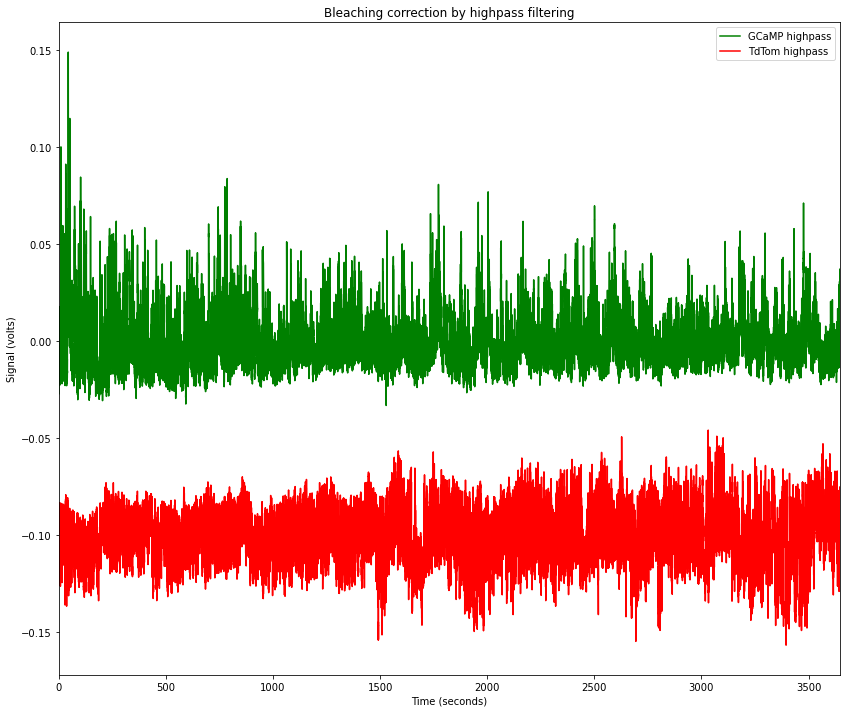

In [22]:
b,a = butter(2, 0.001, btype='high', fs=sampling_rate)
GCaMP_highpass = filtfilt(b,a, GCaMP_denoised, padtype='even')
TdTom_highpass = filtfilt(b,a, TdTom_denoised, padtype='even')

plt.plot(time_seconds, GCaMP_highpass    ,'g', label='GCaMP highpass')
plt.plot(time_seconds, TdTom_highpass-0.1,'r', label='TdTom highpass')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Bleaching correction by highpass filtering')
plt.legend();

Annother way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal. In practice we find that a double exponential fit is preferable because there are typically multiple sources of fluorescence that contribute to the bleaching (e.g. autofluorescence from fiber, autofluorescence from brain tissue, and flurophore fluorescence), which may bleach at different rates, so a single exponential fit can be overly restrictive.

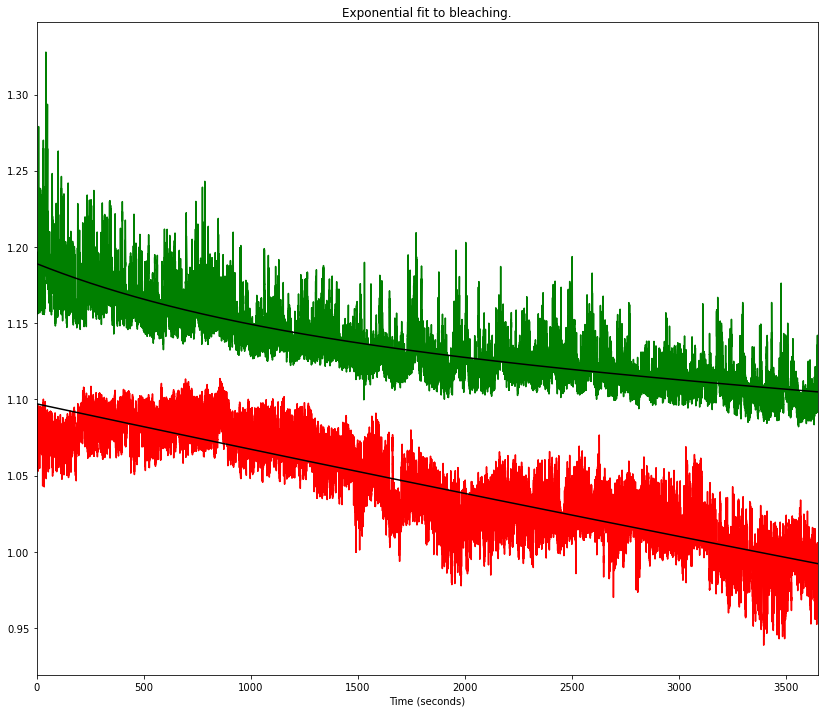

In [23]:
# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset. 
    amp_fast: Amplitude of the fast component.  
    amp_slow: Amplitude of the slow component.  
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow. 
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

# Fit curve to GCaMP signal.
max_sig = np.max(GCaMP_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
GCaMP_parms, parm_cov = curve_fit(double_exponential, time_seconds, GCaMP_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
GCaMP_expfit = double_exponential(time_seconds, *GCaMP_parms)

# Fit curve to TdTomato signal.
max_sig = np.max(TdTom_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
TdTom_parms, parm_cov = curve_fit(double_exponential, time_seconds, TdTom_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
TdTom_expfit = double_exponential(time_seconds, *TdTom_parms)

plt.plot(time_seconds, GCaMP_denoised, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_expfit,'k', linewidth=1.5) 
plt.plot(time_seconds, TdTom_denoised, 'r', label='TdTomato')
plt.plot(time_seconds, TdTom_expfit,'k', linewidth=1.5) 
plt.title('Exponential fit to bleaching.')
plt.xlabel('Time (seconds)');

Now subtract the exponential fits from the signals.

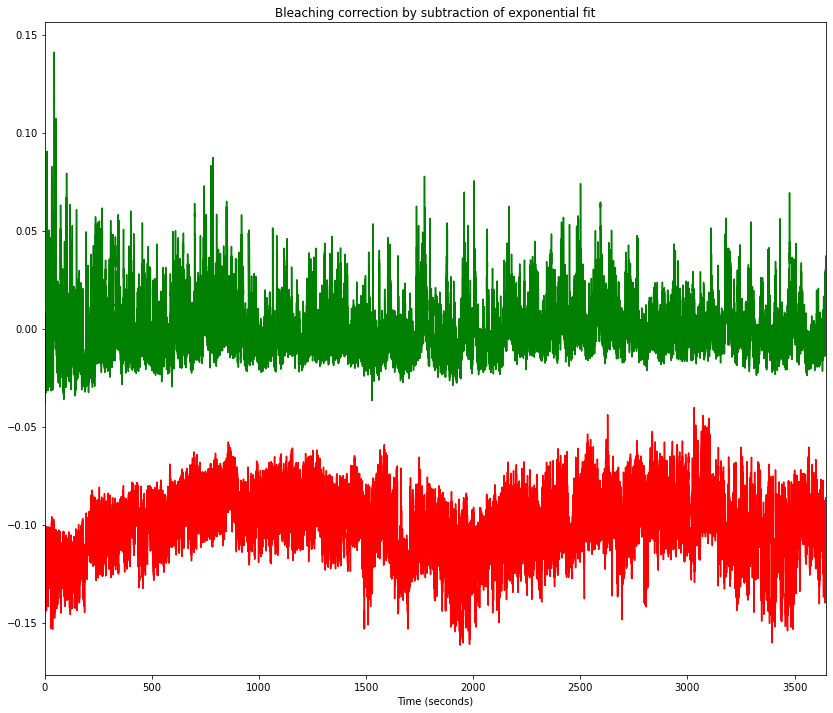

In [24]:
GCaMP_es = GCaMP_denoised - GCaMP_expfit
TdTom_es = TdTom_denoised - TdTom_expfit

plt.plot(time_seconds, GCaMP_es    , 'g', label='GCaMP')
plt.plot(time_seconds, TdTom_es-0.1, 'r', label='TdTomato')
plt.title('Bleaching correction by subtraction of exponential fit')
plt.xlabel('Time (seconds)');

# Motion correction

We now do motion correction by finding the best linear fit of the TdTomato signal to the GCaMP signal and subtracting this estimated motion component from the GCaMP signal.  We will use the data that was bleaching corrected using the double exponential fit as we find that in practice this is less likely to remove meaningful slow variation in the signals.

Slope    : 0.124
R-squared: 0.021


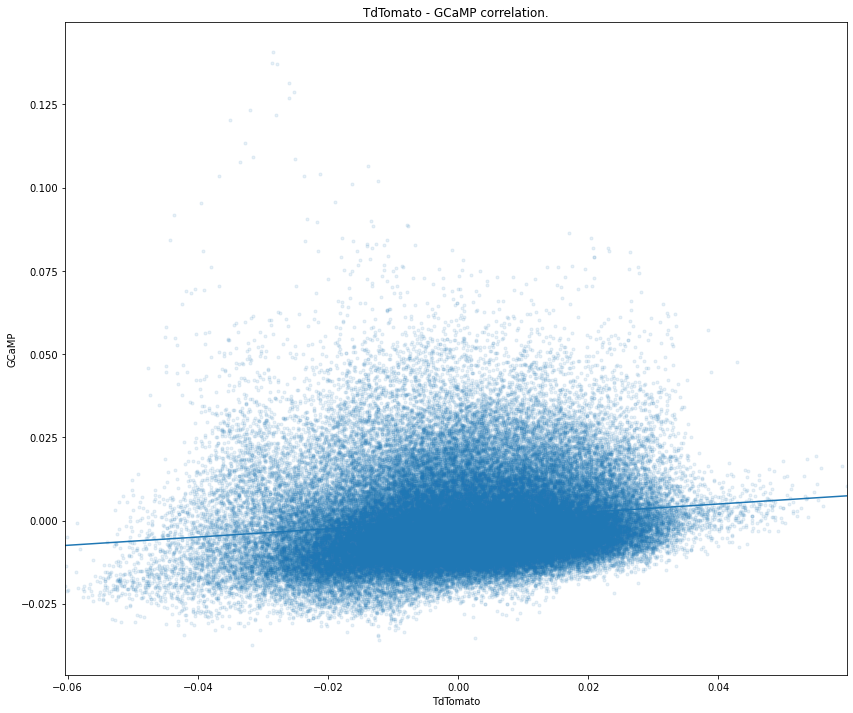

In [25]:
slope, intercept, r_value, p_value, std_err = linregress(x=TdTom_es, y=GCaMP_es)

plt.scatter(TdTom_es[::5], GCaMP_es[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('TdTomato')
plt.ylabel('GCaMP')
plt.title('TdTomato - GCaMP correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

Calculate the estimated motion component of the GCaMP signal and subtract to get motion corrected signal.

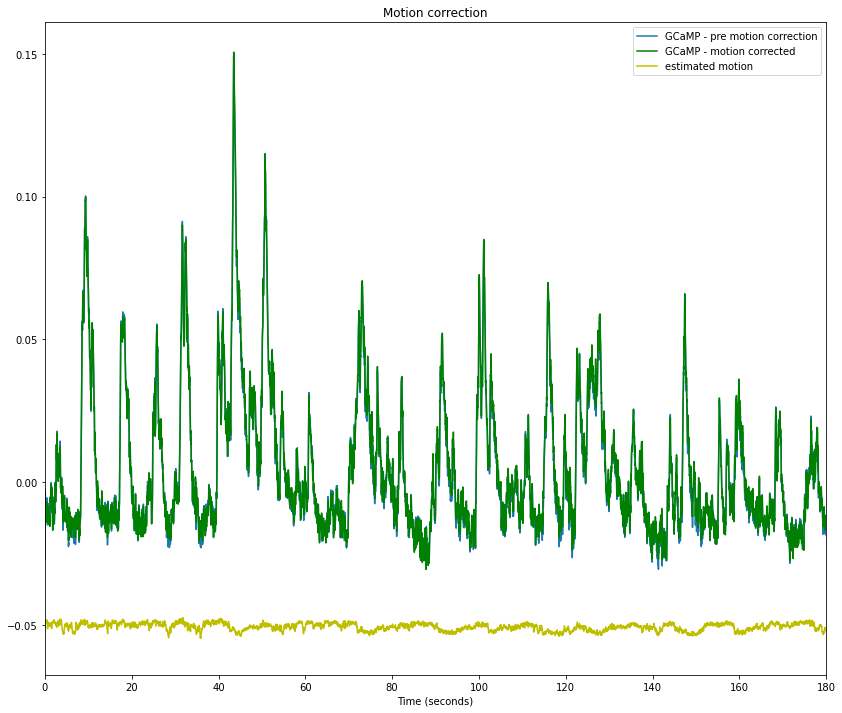

In [26]:
GCaMP_est_motion = intercept + slope * TdTom_highpass
GCaMP_corrected = GCaMP_highpass - GCaMP_est_motion

plt.plot(time_seconds, GCaMP_highpass  , label='GCaMP - pre motion correction')
plt.plot(time_seconds, GCaMP_corrected, 'g', label='GCaMP - motion corrected')
plt.plot(time_seconds, GCaMP_est_motion - 0.05, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction')
plt.legend()
plt.xlim(0,180);

# Normalisation

Typically in a photometry experiment we want to combine data across sessions and/or subjects.  This is complicated by the fact that different sessions may have different levels of fluorphores expression, excitation light and autofluorescence.  It is therefore desirable to normalise the data to reduce this variability.  The two most widely used ways of doing this are computing dF/F or z-scores.

## dF/F

To compute dF/F we divide the signal changes (dF) by the baseline fluorescence (F) and multiply by 100 to convert to percent. The dF is just the motion corrected signal plotted above.  The baseline fluorescence F changes over the course of the session due to photobleaching, and is just the baseline we estimated with our double exponential fit.

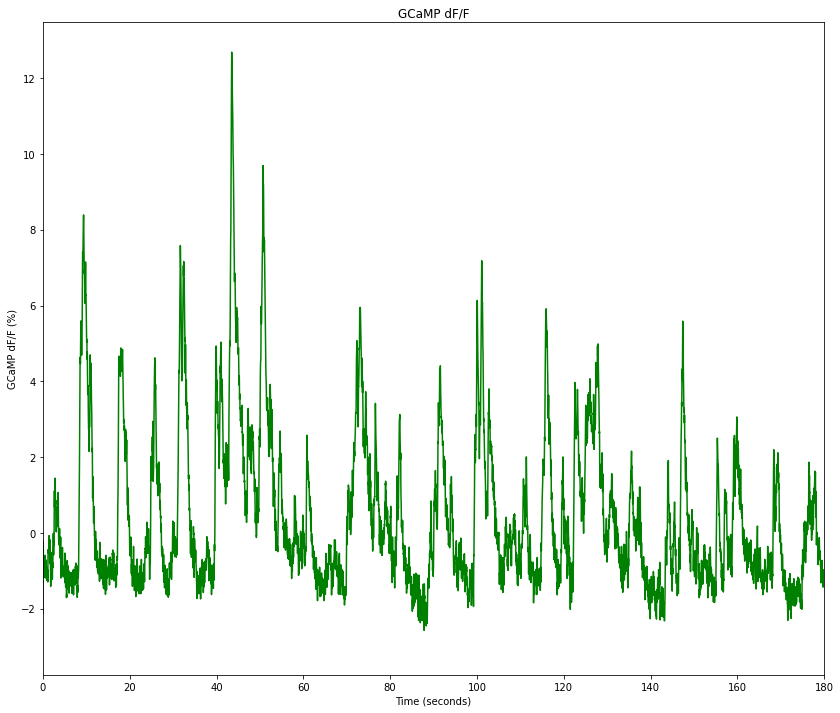

In [27]:
GCaMP_dF_F = 100*GCaMP_corrected/GCaMP_expfit

plt.plot(time_seconds, GCaMP_dF_F, 'g')
plt.xlabel('Time (seconds)')
plt.ylabel('GCaMP dF/F (%)')
plt.title('GCaMP dF/F')
plt.xlim(0,180);

## Z-scoring

Alternatively, we can normalise the data by z-scoring each session - i.e. subtracting the mean and dividing by the standard deviation.

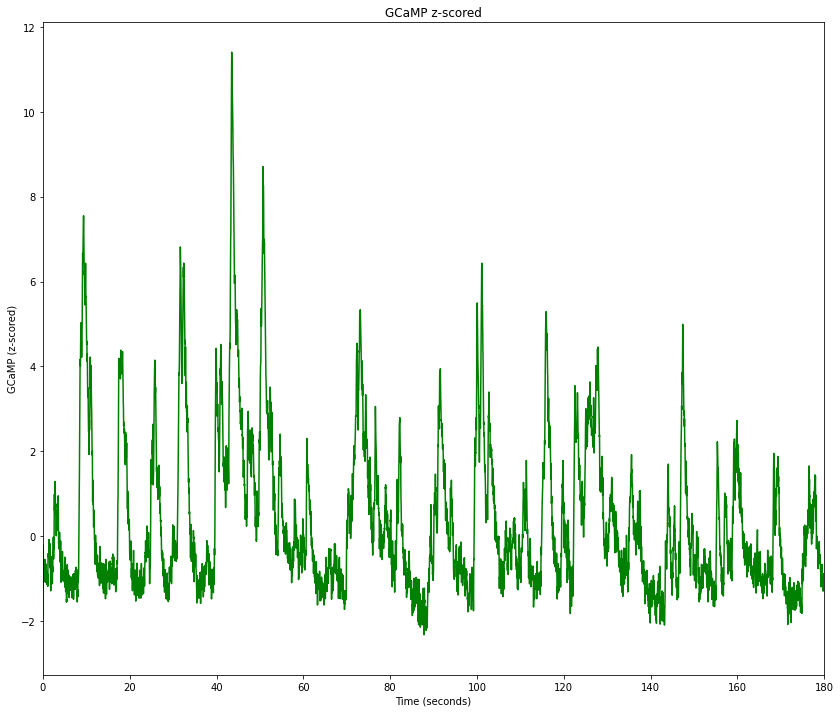

In [28]:
GCaMP_zscored = (GCaMP_corrected-np.mean(GCaMP_corrected))/np.std(GCaMP_corrected)

plt.plot(time_seconds, GCaMP_zscored, 'g')
plt.xlabel('Time (seconds)')
plt.ylabel('GCaMP (z-scored)')
plt.title('GCaMP z-scored')
plt.xlim(0,180);

(c) Copyright Thomas Akam 2019 - 2023.  Released under the [GPL3 Licence](https://www.gnu.org/licenses/gpl-3.0.en.html).